In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_excel("dataset_tugas.xlsx")
df = df.drop("No", axis=1)
X = df.drop("Label", axis=1)
Y = df['Label']
X

,Reviews
0,kemeja nya bagusss bgtttt😍😍😍aaaa mauuu nngisss...
1,"Jahitannya sih rapi,cuman ada benang yang ikut..."
2,Sesuai harga. Agak tipis tapi masih oke kok. W...
3,"Wah gila sihhh sebagus itu, se worth it, se l..."
4,Kain nya bagus halus \nTapi kok di bukak koto...
...,...
826,Terima kasih barang sudah sampai sesuai ukuran...
827,Mantapp realpicttt bangttt tapi pengemasan nya...
828,"Suka bgt sama tasnya, ga kayak tas local. Kere..."
829,kualitas produk sangat baik. produk original. ...


In [2]:
def case_folding(data):
    """
    Lower case kalimat
    menghilangkan new line, karakter selain huruf dan spasi, 
    serta angka

    """
    data = data.lower()
    data = data.replace('\n',' ')               
    data = re.sub('[^\w\s]+', ' ',data)         
    data = re.sub('\d+', '', data)             
    return data

X['Reviews'] = X['Reviews'].apply(case_folding)
X

,Reviews
0,kemeja nya bagusss bgtttt aaaa mauuu nngisssss...
1,jahitannya sih rapi cuman ada benang yang ikut...
2,sesuai harga agak tipis tapi masih oke kok w...
3,wah gila sihhh sebagus itu se worth it se l...
4,kain nya bagus halus tapi kok di bukak kotor...
...,...
826,terima kasih barang sudah sampai sesuai ukuran...
827,mantapp realpicttt bangttt tapi pengemasan nya...
828,suka bgt sama tasnya ga kayak tas local kere...
829,kualitas produk sangat baik produk original ...


In [3]:
def tokenisasi(text):
    return word_tokenize(text)

X['Reviews_token'] = X["Reviews"].apply(tokenisasi)
X

,Reviews,Reviews_token
0,kemeja nya bagusss bgtttt aaaa mauuu nngisssss...,"[kemeja, nya, bagusss, bgtttt, aaaa, mauuu, nn..."
1,jahitannya sih rapi cuman ada benang yang ikut...,"[jahitannya, sih, rapi, cuman, ada, benang, ya..."
2,sesuai harga agak tipis tapi masih oke kok w...,"[sesuai, harga, agak, tipis, tapi, masih, oke,..."
3,wah gila sihhh sebagus itu se worth it se l...,"[wah, gila, sihhh, sebagus, itu, se, worth, it..."
4,kain nya bagus halus tapi kok di bukak kotor...,"[kain, nya, bagus, halus, tapi, kok, di, bukak..."
...,...,...
826,terima kasih barang sudah sampai sesuai ukuran...,"[terima, kasih, barang, sudah, sampai, sesuai,..."
827,mantapp realpicttt bangttt tapi pengemasan nya...,"[mantapp, realpicttt, bangttt, tapi, pengemasa..."
828,suka bgt sama tasnya ga kayak tas local kere...,"[suka, bgt, sama, tasnya, ga, kayak, tas, loca..."
829,kualitas produk sangat baik produk original ...,"[kualitas, produk, sangat, baik, produk, origi..."


In [4]:
kamus_alay = pd.read_csv("colloquial-indonesian-lexicon.csv")
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis=1)

dict_normalisasi1 = dict(kamus_alay.values)
dict_normalisasi2 = {
    "murceeee" : "murah",
    "thank" : "terima kasih",
    "enggak" : "tidak",
    "makasihh" : "terima kasih",
    "badaiii" : "badai",
    "pertahankann" : "pertahankan",
    "chek" : "cek",
    "tengkyu" : "terima kasih",
    "dtang" : "datang",
    "terimakasih" : "terima kasih",
    "papa" : "kenapa",
    "banget" : "sangat",
    "kayak" : "seperti",
    "cuman" : "hanya",
    "kalo" : "kalau",
    "pcs" : "pieces",
    "tau" : "tahu",
    "gede" : "besar",
    "nih" : "ini",
    "oke" : "bagus",
    "kak" : "kakak"
}
def normalisasi_pertama(document):
    """
    Melakukan normalisasi kata berdasarkan data pada kamus_alay
    Me-return list baru yang berisi token yang sudah berkata baku sesuai dengan data
    """
    return [
        dict_normalisasi1[token] if token in dict_normalisasi1 else token
        for token in document
    ]

def normalisasi_kedua(document):
    """
    Melakukan normalisasi kata berdasarkan data yang sudah didefinisikan sebelumnya (static)
    Me-return list baru yang berisi token yang sudah berkata baku sesuai dengan data
    """
    return [
        dict_normalisasi2[token] if token in dict_normalisasi2 else token
        for token in document
    ]

X["Reviews_normalisasi"] = X['Reviews_token'].apply(normalisasi_pertama).apply(normalisasi_kedua)
X

,Reviews,Reviews_token,Reviews_normalisasi
0,kemeja nya bagusss bgtttt aaaa mauuu nngisssss...,"[kemeja, nya, bagusss, bgtttt, aaaa, mauuu, nn...","[kemeja, nya, bagus, sangat, aaaa, mau, nngiss..."
1,jahitannya sih rapi cuman ada benang yang ikut...,"[jahitannya, sih, rapi, cuman, ada, benang, ya...","[jahitannya, sih, rapi, hanya, ada, benang, ya..."
2,sesuai harga agak tipis tapi masih oke kok w...,"[sesuai, harga, agak, tipis, tapi, masih, oke,...","[sesuai, harga, agak, tipis, tapi, masih, bagu..."
3,wah gila sihhh sebagus itu se worth it se l...,"[wah, gila, sihhh, sebagus, itu, se, worth, it...","[wah, gila, sih, sebagus, itu, se, worth, itu,..."
4,kain nya bagus halus tapi kok di bukak kotor...,"[kain, nya, bagus, halus, tapi, kok, di, bukak...","[kain, nya, bagus, halus, tapi, kok, di, buka,..."
...,...,...,...
826,terima kasih barang sudah sampai sesuai ukuran...,"[terima, kasih, barang, sudah, sampai, sesuai,...","[terima, kasih, barang, sudah, sampai, sesuai,..."
827,mantapp realpicttt bangttt tapi pengemasan nya...,"[mantapp, realpicttt, bangttt, tapi, pengemasa...","[mantap, realpicttt, bangttt, tapi, pengemasan..."
828,suka bgt sama tasnya ga kayak tas local kere...,"[suka, bgt, sama, tasnya, ga, kayak, tas, loca...","[suka, sangat, sama, tasnya, tidak, seperti, t..."
829,kualitas produk sangat baik produk original ...,"[kualitas, produk, sangat, baik, produk, origi...","[kualitas, produk, sangat, baik, produk, origi..."


In [5]:
list_stopwords = stopwords.words('indonesian')
stopwords_buatan = ["nya","lu","sih","hhe"]
list_stopwords_baru = list_stopwords + stopwords_buatan


def hapus_stopwords(words):
    """
    Me-return list baru yang berisi kata yang tidak berada di list stopwords
    """
    return [
        word for word in words if word not in list_stopwords_baru
    ]

X["Reviews_stopword"] = X["Reviews_normalisasi"].apply(hapus_stopwords)
X

,Reviews,Reviews_token,Reviews_normalisasi,Reviews_stopword
0,kemeja nya bagusss bgtttt aaaa mauuu nngisssss...,"[kemeja, nya, bagusss, bgtttt, aaaa, mauuu, nn...","[kemeja, nya, bagus, sangat, aaaa, mau, nngiss...","[kemeja, bagus, aaaa, nngisssss, beli, kemeja,..."
1,jahitannya sih rapi cuman ada benang yang ikut...,"[jahitannya, sih, rapi, cuman, ada, benang, ya...","[jahitannya, sih, rapi, hanya, ada, benang, ya...","[jahitannya, rapi, benang, jahit, jelek]"
2,sesuai harga agak tipis tapi masih oke kok w...,"[sesuai, harga, agak, tipis, tapi, masih, oke,...","[sesuai, harga, agak, tipis, tapi, masih, bagu...","[sesuai, harga, tipis, bagus, warnanya, abu, d..."
3,wah gila sihhh sebagus itu se worth it se l...,"[wah, gila, sihhh, sebagus, itu, se, worth, it...","[wah, gila, sih, sebagus, itu, se, worth, itu,...","[gila, sebagus, worth, lembut, bajunya, tipis,..."
4,kain nya bagus halus tapi kok di bukak kotor...,"[kain, nya, bagus, halus, tapi, kok, di, bukak...","[kain, nya, bagus, halus, tapi, kok, di, buka,...","[kain, bagus, halus, buka, kotor, ya, warna, p..."
...,...,...,...,...
826,terima kasih barang sudah sampai sesuai ukuran...,"[terima, kasih, barang, sudah, sampai, sesuai,...","[terima, kasih, barang, sudah, sampai, sesuai,...","[terima, kasih, barang, sesuai, ukuran, seesua..."
827,mantapp realpicttt bangttt tapi pengemasan nya...,"[mantapp, realpicttt, bangttt, tapi, pengemasa...","[mantap, realpicttt, bangttt, tapi, pengemasan...","[mantap, realpicttt, bangttt, pengemasan, plas..."
828,suka bgt sama tasnya ga kayak tas local kere...,"[suka, bgt, sama, tasnya, ga, kayak, tas, loca...","[suka, sangat, sama, tasnya, tidak, seperti, t...","[suka, tasnya, tas, local, keren, parah, pokok..."
829,kualitas produk sangat baik produk original ...,"[kualitas, produk, sangat, baik, produk, origi...","[kualitas, produk, sangat, baik, produk, origi...","[kualitas, produk, produk, original, harga, pr..."


In [6]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()


def stemming(term):
    return stemmer.stem(term)

X["Reviews_clean"] = [' '.join(map(str, l)) for l in X["Reviews_stopword"]]
X["Reviews_stem"] = X["Reviews_clean"].apply(stemming)
X

,Reviews,Reviews_token,Reviews_normalisasi,Reviews_stopword,Reviews_clean,Reviews_stem
0,kemeja nya bagusss bgtttt aaaa mauuu nngisssss...,"[kemeja, nya, bagusss, bgtttt, aaaa, mauuu, nn...","[kemeja, nya, bagus, sangat, aaaa, mau, nngiss...","[kemeja, bagus, aaaa, nngisssss, beli, kemeja,...",kemeja bagus aaaa nngisssss beli kemeja ditoko...,kemeja bagus aaaa nngisssss beli kemeja toko k...
1,jahitannya sih rapi cuman ada benang yang ikut...,"[jahitannya, sih, rapi, cuman, ada, benang, ya...","[jahitannya, sih, rapi, hanya, ada, benang, ya...","[jahitannya, rapi, benang, jahit, jelek]",jahitannya rapi benang jahit jelek,jahit rapi benang jahit jelek
2,sesuai harga agak tipis tapi masih oke kok w...,"[sesuai, harga, agak, tipis, tapi, masih, oke,...","[sesuai, harga, agak, tipis, tapi, masih, bagu...","[sesuai, harga, tipis, bagus, warnanya, abu, d...",sesuai harga tipis bagus warnanya abu difoto b...,sesuai harga tipis bagus warna abu foto biru d...
3,wah gila sihhh sebagus itu se worth it se l...,"[wah, gila, sihhh, sebagus, itu, se, worth, it...","[wah, gila, sih, sebagus, itu, se, worth, itu,...","[gila, sebagus, worth, lembut, bajunya, tipis,...",gila sebagus worth lembut bajunya tipis kaya k...,gila bagus worth lembut baju tipis kaya kemeja...
4,kain nya bagus halus tapi kok di bukak kotor...,"[kain, nya, bagus, halus, tapi, kok, di, bukak...","[kain, nya, bagus, halus, tapi, kok, di, buka,...","[kain, bagus, halus, buka, kotor, ya, warna, p...",kain bagus halus buka kotor ya warna putih,kain bagus halus buka kotor ya warna putih
...,...,...,...,...,...,...
826,terima kasih barang sudah sampai sesuai ukuran...,"[terima, kasih, barang, sudah, sampai, sesuai,...","[terima, kasih, barang, sudah, sampai, sesuai,...","[terima, kasih, barang, sesuai, ukuran, seesua...",terima kasih barang sesuai ukuran seesuai gamb...,terima kasih barang sesuai ukur seesuai gambar...
827,mantapp realpicttt bangttt tapi pengemasan nya...,"[mantapp, realpicttt, bangttt, tapi, pengemasa...","[mantap, realpicttt, bangttt, tapi, pengemasan...","[mantap, realpicttt, bangttt, pengemasan, plas...",mantap realpicttt bangttt pengemasan plastik k...,mantap realpicttt bangttt emas plastik ku paka...
828,suka bgt sama tasnya ga kayak tas local kere...,"[suka, bgt, sama, tasnya, ga, kayak, tas, loca...","[suka, sangat, sama, tasnya, tidak, seperti, t...","[suka, tasnya, tas, local, keren, parah, pokok...",suka tasnya tas local keren parah pokoknyaaaaa...,suka tas tas local keren parah pokoknyaaaaa su...
829,kualitas produk sangat baik produk original ...,"[kualitas, produk, sangat, baik, produk, origi...","[kualitas, produk, sangat, baik, produk, origi...","[kualitas, produk, produk, original, harga, pr...",kualitas produk produk original harga produk,kualitas produk produk original harga produk


In [68]:
documents = X['Reviews_stem']
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(documents)

chi2_scores, _ = chi2(X_tfidf, Y)
scores_dict = dict(zip(vectorizer.get_feature_names_out(), chi2_scores))

"""
    Eksperimen nilai fitur terbaik dari chi square
    10% = 181
    20% = 363
    30% = 544
    40% = 726
"""
k=544
top_features = sorted(scores_dict, key=scores_dict.get, reverse=True)[:k]

new_vectorizer = TfidfVectorizer(vocabulary=top_features)
X_new = new_vectorizer.fit_transform(documents)
feature_names = new_vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(X_new.toarray(), columns=feature_names)
df_tfidf

,bagus,cepat,adem,pokok,rusak,terima,jam,warna,pesan,kualitas,...,tudung,buang,lengen,versi,bete,inepin,syukaaa,out,couple,gelang
0,0.288000,0.0,0.160637,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.156020,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.208411,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.121383,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.192697,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.257404,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,0.176566,0.0,0.000000,0.000000,0.0,0.507537,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
827,0.138976,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
828,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
829,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.259843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
X_train,X_test,Y_train,Y_test=train_test_split(df_tfidf,Y,test_size=0.2,random_state=21)

Akurasi  0.8862275449101796
Precision  0.8148148148148148
Recall  0.9428571428571428
F1-skor  0.8741721854304636


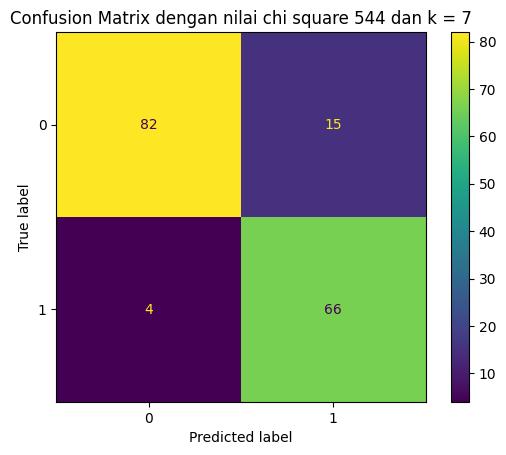

In [74]:
"""
Eksperimen nilai k=3, 5, 7, 9
"""
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
accuracy_score(Y_test, y_pred)

accuracy_model = accuracy_score(Y_test, y_pred)
precision_model = precision_score(Y_test, y_pred)
recall_model = recall_score(Y_test, y_pred)
skor_f1_model = f1_score(Y_test, y_pred)

print("Akurasi ", accuracy_model)
print("Precision ", precision_model)
print("Recall ", recall_model)
print("F1-skor ", skor_f1_model)


cm = confusion_matrix(Y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix dengan nilai chi square 544 dan k = 7")
plt.show()

In [10]:
import pickle
with open('new_vectorizer.pkl', 'wb') as f:
    pickle.dump(new_vectorizer, f)

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(model, f)